In [1]:
!pip install -U scikit-learn
!pip install lightgbm
!pip install -U ml-research

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached lightgbm-4.4.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
Using cached lightgbm-4.4.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached ml_research-0.5.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached ml_research-0.5.1-py3-none-any.whl (104 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)


In [23]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity, outcome_sensitivity,
    bootstrapped_explanation_consistency, cross_method_explanation_consistency,
    cross_method_outcome_consistency, explanation_sensitivity_all_neighbors
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [24]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
qids_train = X.index.value_counts().to_numpy()

model = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
model.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [25]:
datasets = [
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=0, item_num=5000)),
        "scorer": synthetic_equal_score_3ftrs,
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=1, item_num=5000)),
        "scorer": synthetic_equal_score_3ftrs,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(fetch_synthetic_data(synth_dt_version=2, item_num=5000)),
        "scorer": synthetic_equal_score_3ftrs,
    },
]

xai_methods = [
    {
        "iterations": 1,
        "name": "SHAP",
        "experiment": shap_experiment,
        "kwargs": {}
    },
    {
        "iterations": 1,
        "name": "ShaRPrank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True,
            "qoi": "rank"
        }
    },
    {
        "iterations": 1,
        "name": "ShaRPscore",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            # "sample_size": 150,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": True,
            "qoi": "rank_score"
        }
    },
    # {
    #     "iterations": 1,
    #     "name": "ShaRP",
    #     "experiment": sharp_experiment,
    #     "kwargs": {
    #         "verbose": True,
    #         # "sample_size": 150,
    #         "measure": "shapley",
    #         "n_jobs": -1,
    #         "replace": True,
    #         "qoi": "top_k"
    #     }
    # },
]

total_states = sum(map(lambda x: x["iterations"], xai_methods)) * len(datasets)
random_states = (x for x in check_random_states(RNG_SEED, total_states))

In [5]:
results = {}
for dataset in datasets:
    results[dataset["name"]] = {}
    for xai_method in xai_methods:
        results[dataset["name"]][xai_method["name"]] = []

        experiment_func = xai_method["experiment"]
        score_func = dataset["scorer"]

        X, ranks, scores = dataset["data"]

        for iteration_idx in range(xai_method["iterations"]):
            random_state = next(random_states)
            if "done" in dataset and dataset["done"]:
                continue

            kwargs = {} if "kwargs" not in xai_method else xai_method["kwargs"]
            if dataset["name"] == "Moving Company" and xai_method["name"].endswith("ShaRP"):
                kwargs["sample_size"] = 150

            contributions = experiment_func(X, score_func, random_state=random_state, **kwargs)

            results[dataset["name"]][xai_method["name"]].append(contributions)
            result_df = pd.DataFrame(contributions, columns=X.columns, index=X.index)
            result_df.to_csv(
                f"results/_contributions_{dataset['name']}_{xai_method['name']}_{iteration_idx}.csv"
            )

ExactExplainer explainer: 5001it [00:11, 83.63it/s]                           


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [26]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/_contributions_"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}_"
                    f"{iteration}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

In [27]:
results = read_results_from_files()

In [28]:
results

{'Synthetic_0': {'SHAP': [            n1        n2        n3
   0    -0.015593  0.025277 -0.032194
   1    -0.027940 -0.010954  0.005383
   2     0.032573 -0.014169  0.094329
   3    -0.099863 -0.005156  0.027519
   4    -0.042513  0.033307 -0.077390
   ...        ...       ...       ...
   4995  0.021530  0.058506 -0.071549
   4996 -0.038154 -0.005450  0.057042
   4997 -0.018645 -0.031533 -0.037734
   4998 -0.061172 -0.001532 -0.062396
   4999 -0.036062 -0.024422 -0.029557
   
   [5000 rows x 3 columns]],
  'ShaRPrank': [               n1           n2           n3
   0     -322.214967   499.384200  -754.040400
   1     -589.196900  -239.290367    -5.309467
   2      629.099800  -101.169800  1604.900067
   3    -1884.675067  -140.997467   334.893267
   4     -785.428333   495.929100 -1513.880200
   ...           ...          ...          ...
   4995   456.980833  1164.474400 -1407.418633
   4996  -705.278933   -57.704367  1101.714700
   4997  -394.304867  -622.457600  -807.581200
   49

# Explanation Sensitivity

In [29]:
help(explanation_sensitivity)

Help on function explanation_sensitivity in module xai_ranking.metrics._sensitivity:

explanation_sensitivity(original_data, contributions, rankings, n_neighbors=10, agg_type='mean', measure='kendall', similar_outcome=True, **kwargs)



In [30]:
methods = [method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")]

expl_sens_res = {}
expl_sens_sem = {}
for method in methods:
    expl_sens_res[method] = {}
    expl_sens_sem[method] = {}
    for dataset in datasets:
        try:
            rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
            result = explanation_sensitivity(
                dataset["data"][0], 
                results[dataset["name"]][method][0],
                rankings,
                measure="euclidean"
            )
            expl_sens_res[method][dataset["name"]] = result[0]
            expl_sens_sem[method][dataset["name"]] = result[1]
        except:
            pass

In [31]:
pd.DataFrame(expl_sens_res)

SHAP  ShaRPrank  ShaRPscore
Synthetic_0  0.903737   0.909399    0.904607
Synthetic_1  0.869211   0.892290    0.877040
Synthetic_2  0.844930   0.857320    0.847343

## Reverse explanation sensitivity

In [32]:
methods = [method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")]

expl_sens_res = {}
expl_sens_sem = {}
for method in methods:
    expl_sens_res[method] = {}
    expl_sens_sem[method] = {}
    for dataset in datasets:
        try:
            rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
            result = explanation_sensitivity(
                dataset["data"][0], 
                results[dataset["name"]][method][0],
                rankings,
                measure="euclidean",
                # n_features=0.8,
                similar_outcome = False
            )
            expl_sens_res[method][dataset["name"]] = result[0]
            expl_sens_sem[method][dataset["name"]] = result[1]
        except:
            pass

In [33]:
pd.DataFrame(expl_sens_res)

SHAP  ShaRPrank  ShaRPscore
Synthetic_0  0.899449   0.904803    0.899684
Synthetic_1  0.856913   0.878009    0.864215
Synthetic_2  0.862501   0.866512    0.858967

## Explanation Sensitivity Plot

In [34]:
import seaborn as sns

5000


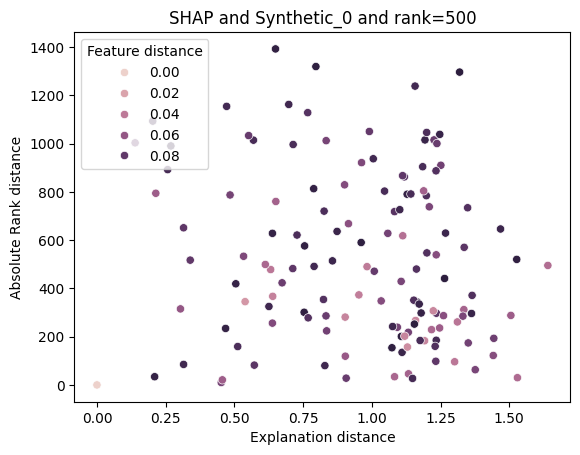

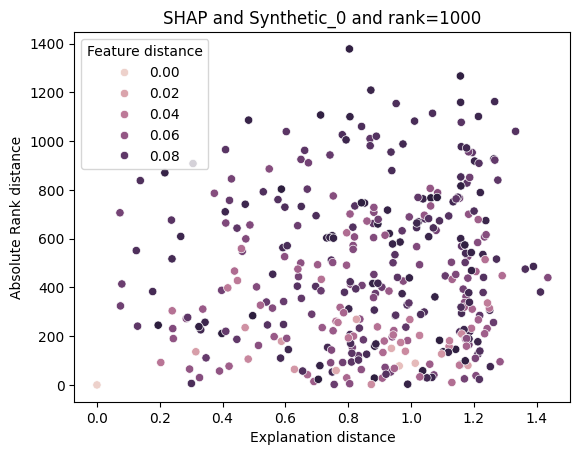

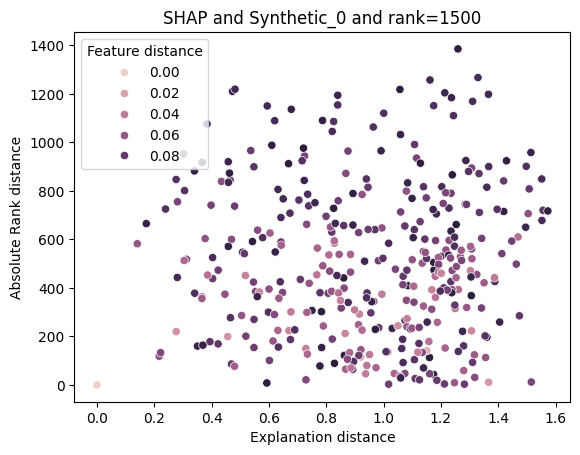

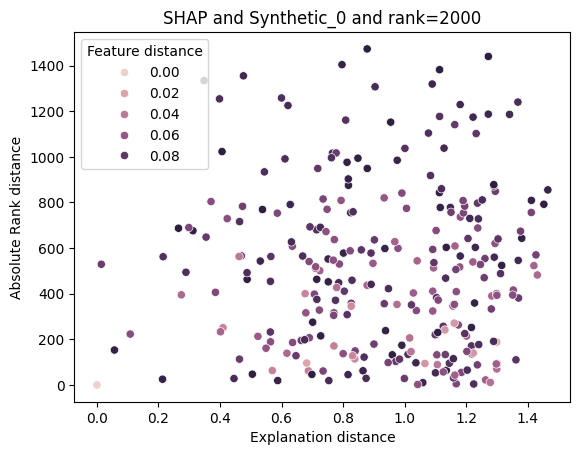

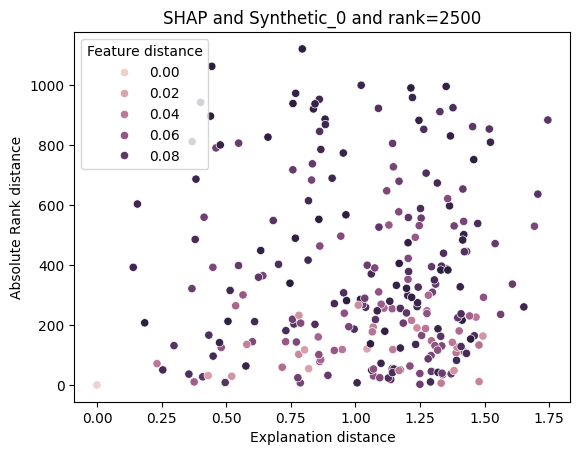

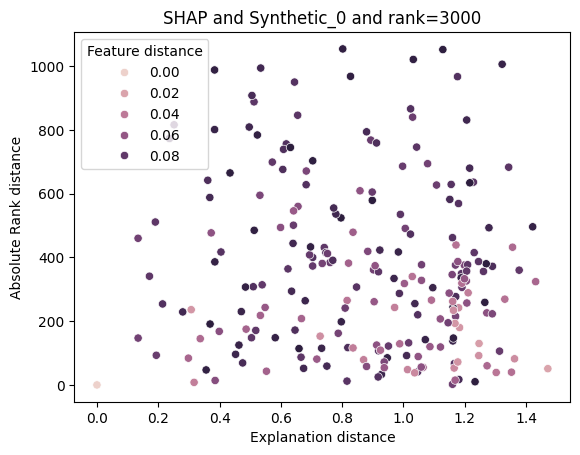

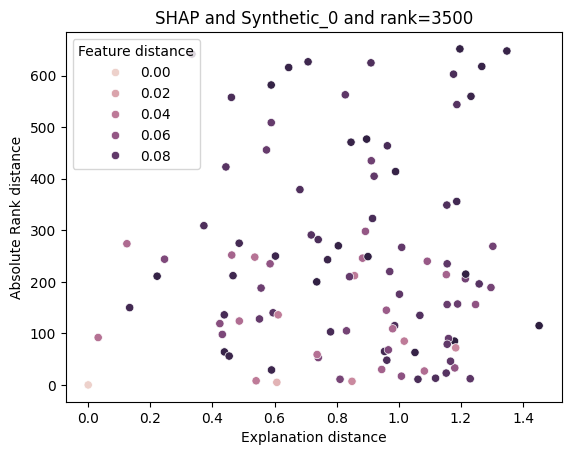

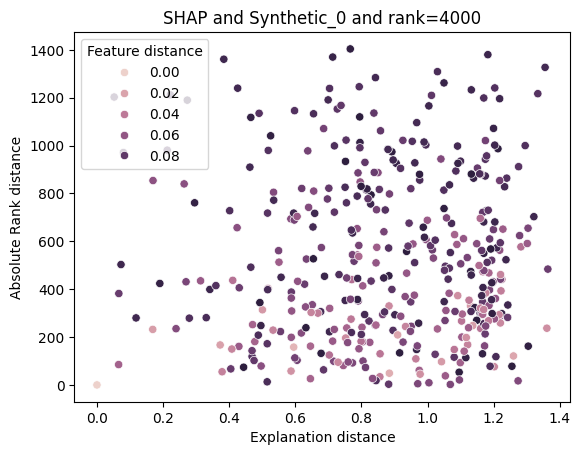

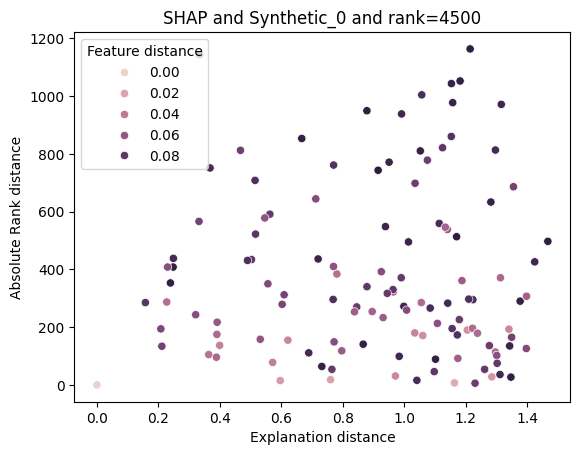

5000


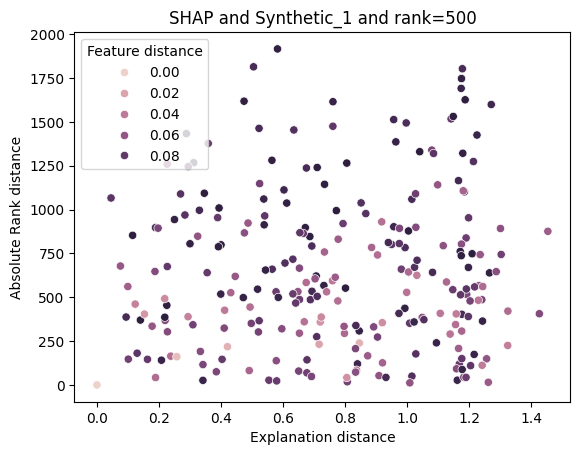

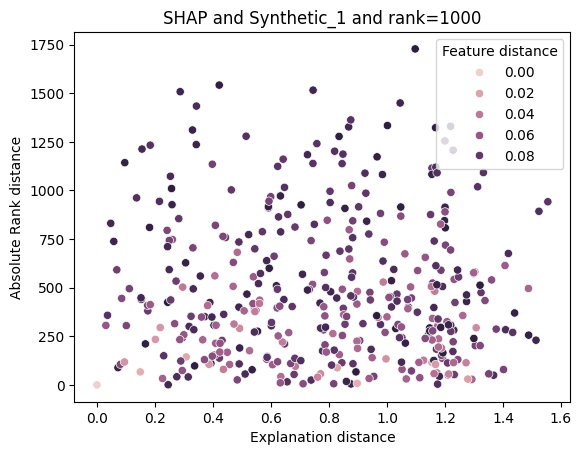

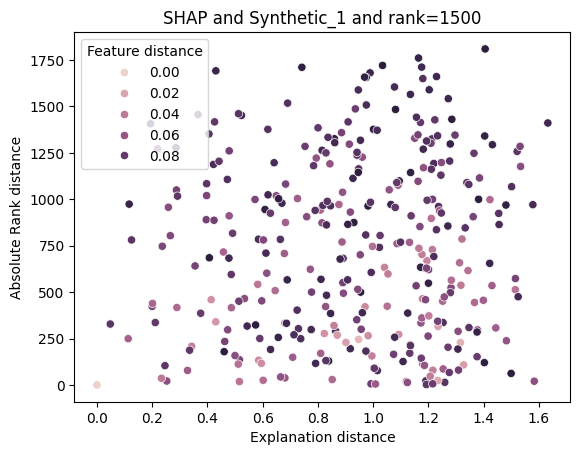

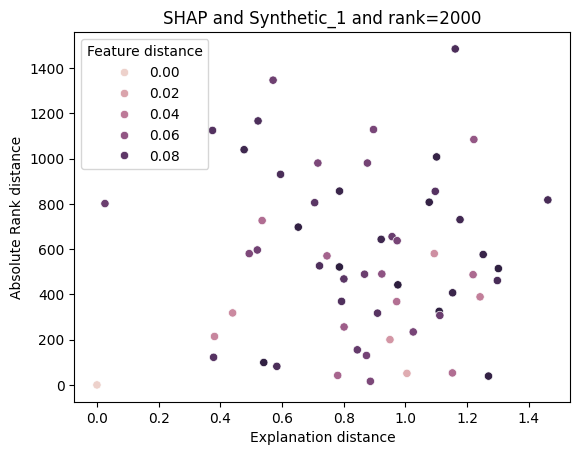

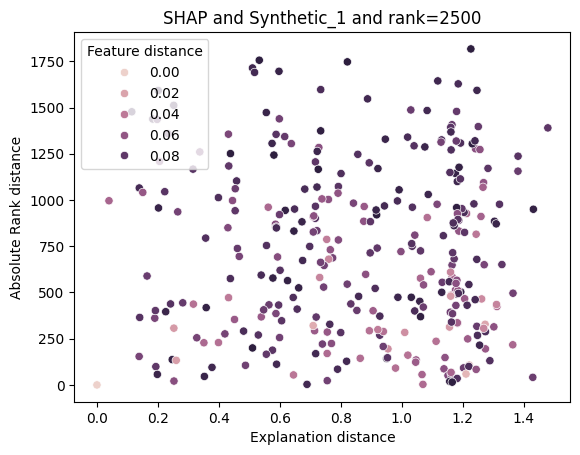

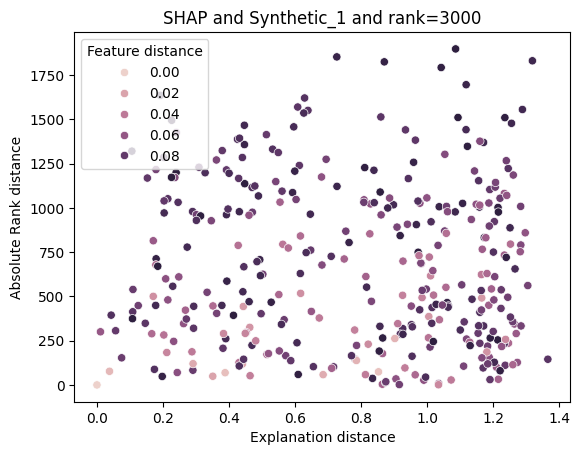

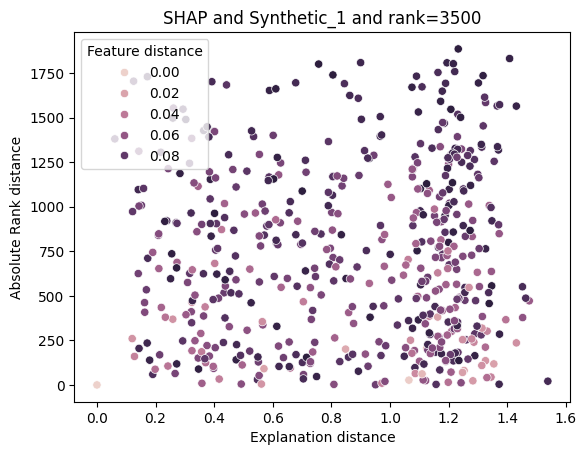

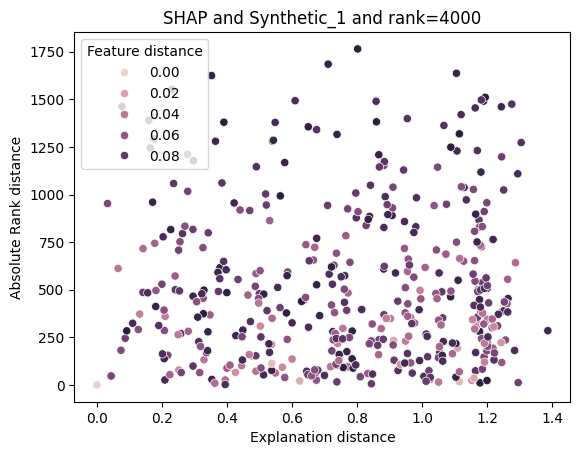

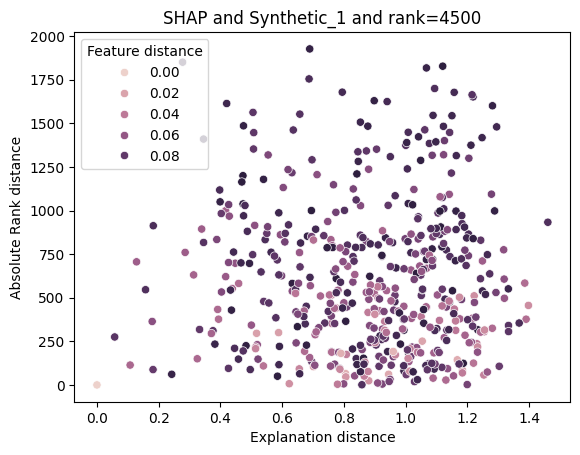

5000


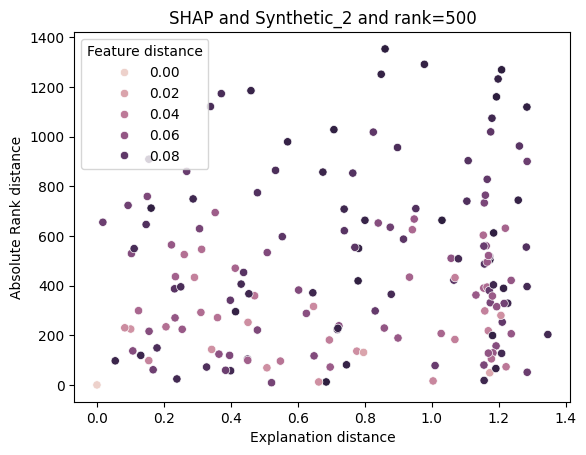

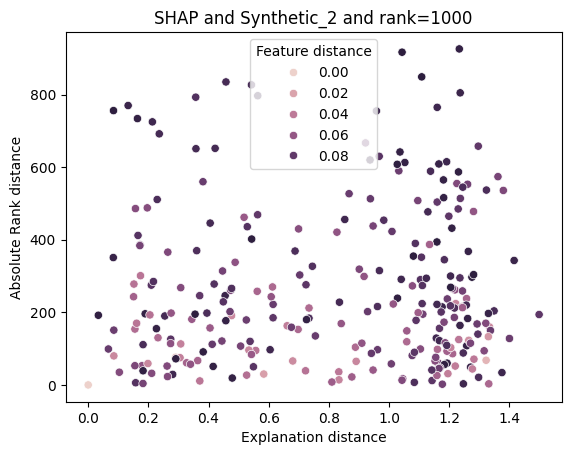

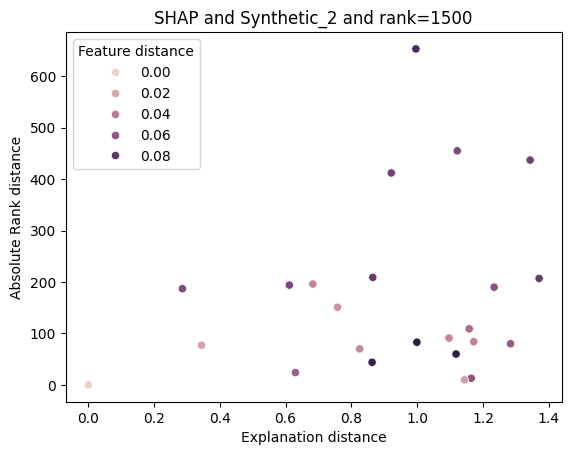

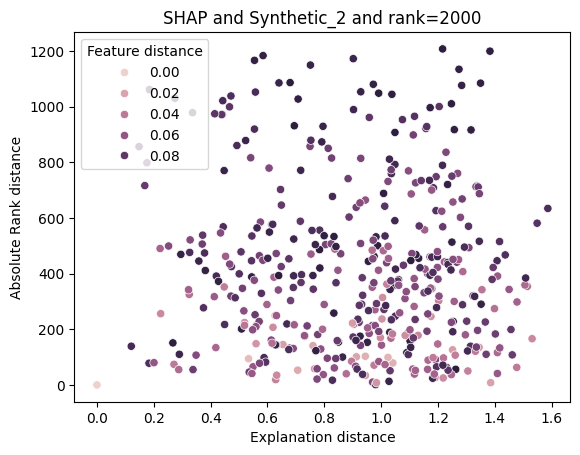

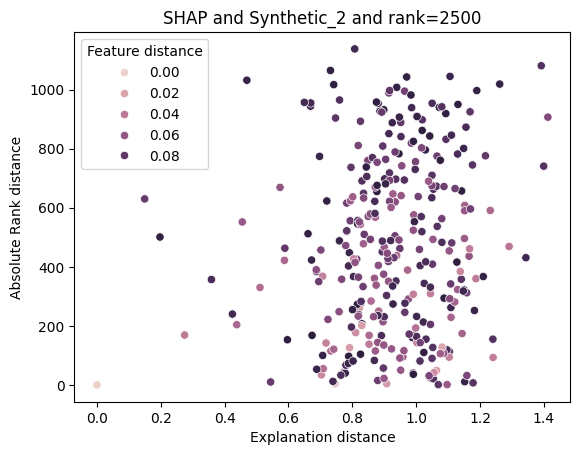

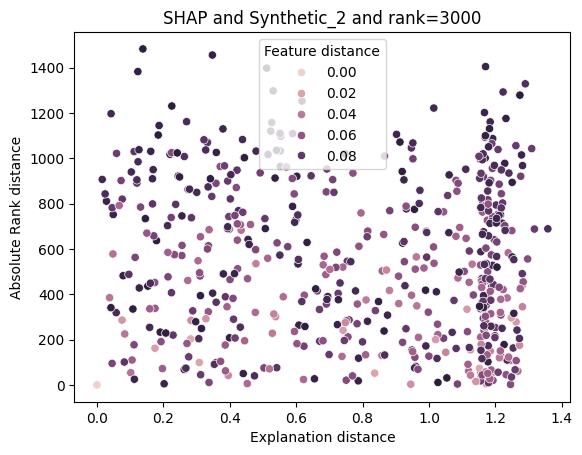

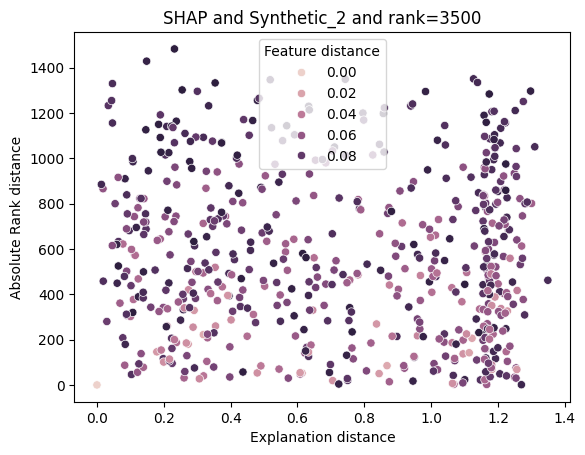

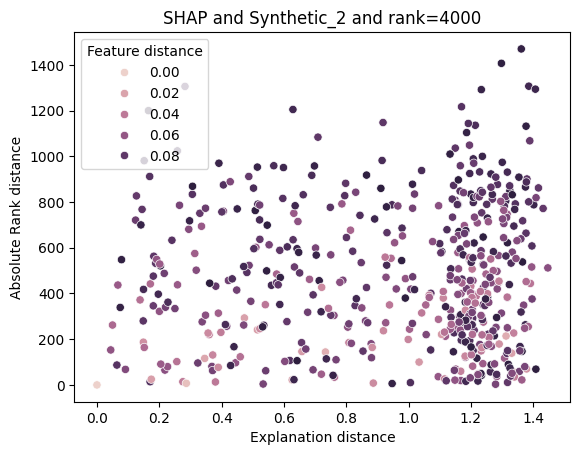

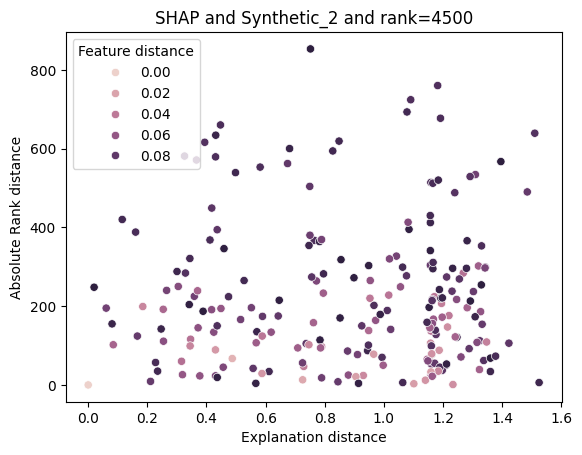

5000


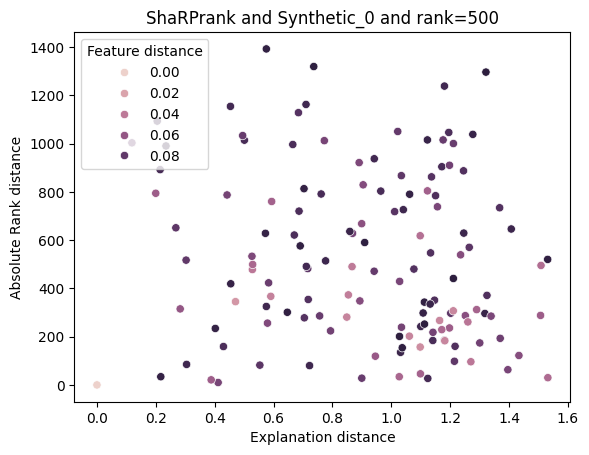

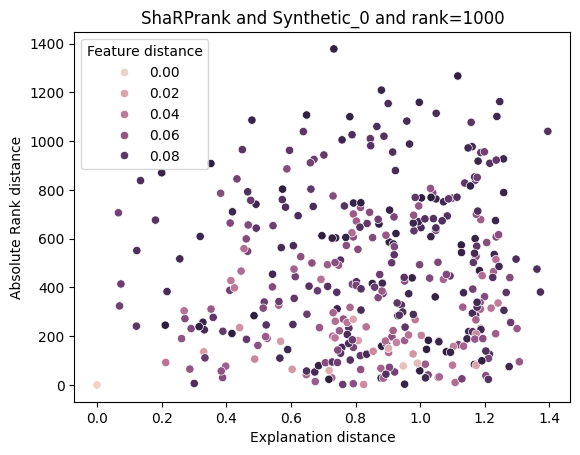

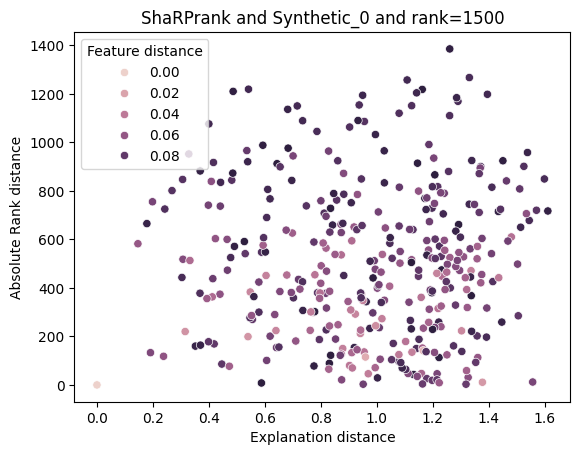

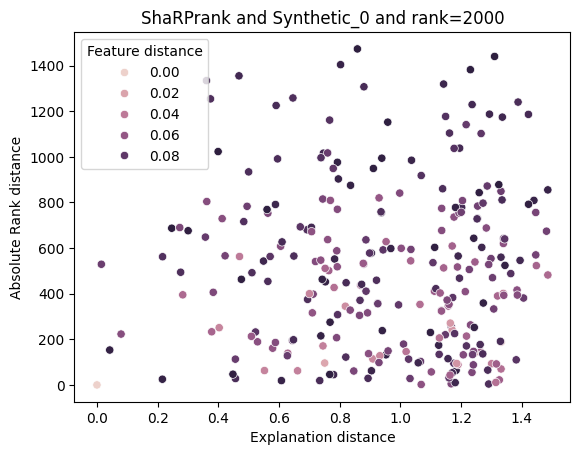

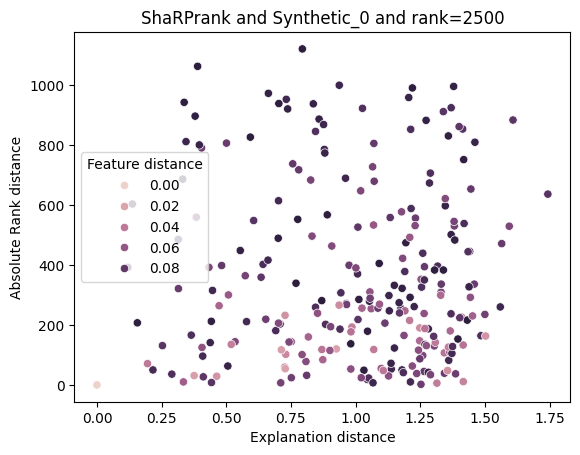

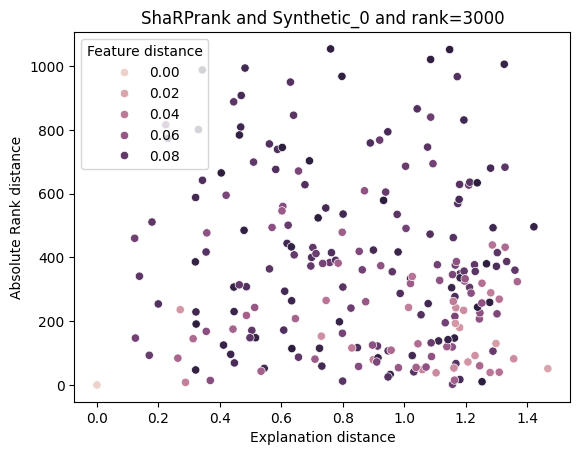

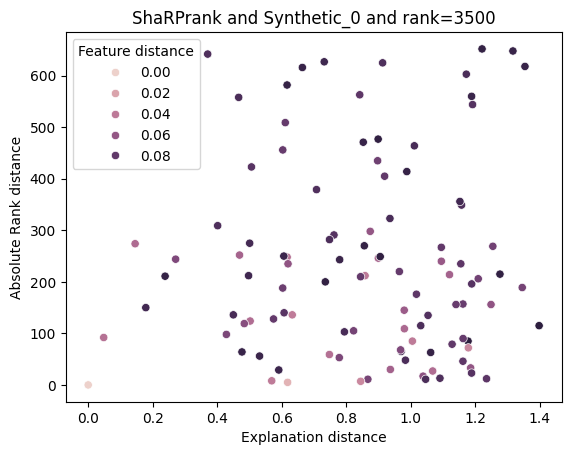

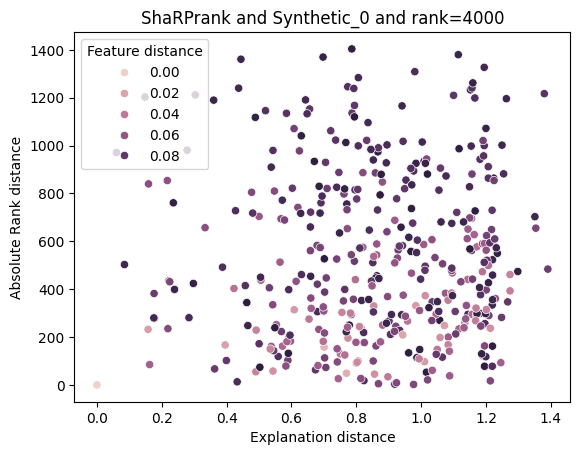

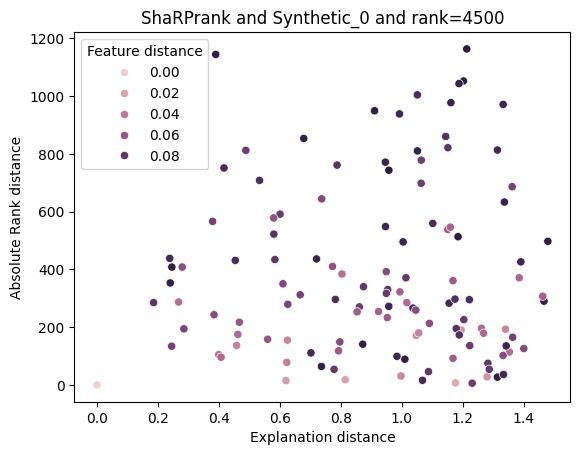

5000


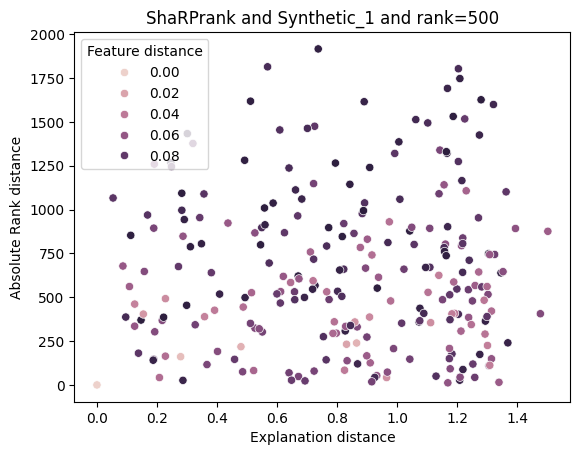

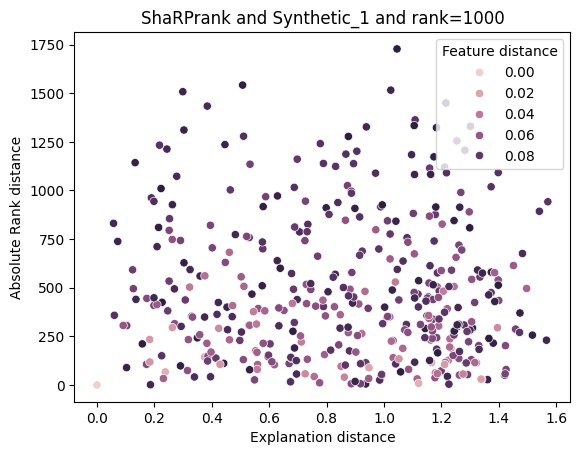

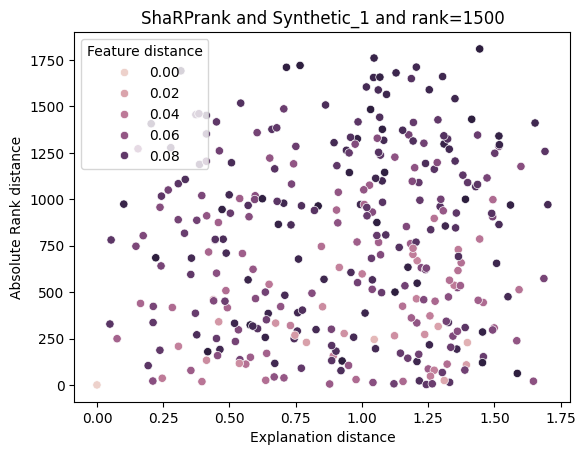

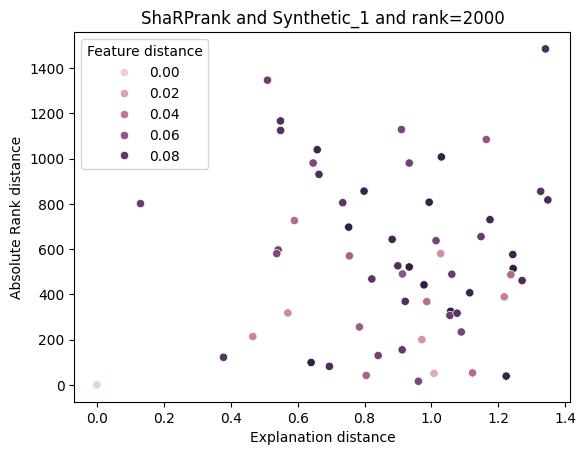

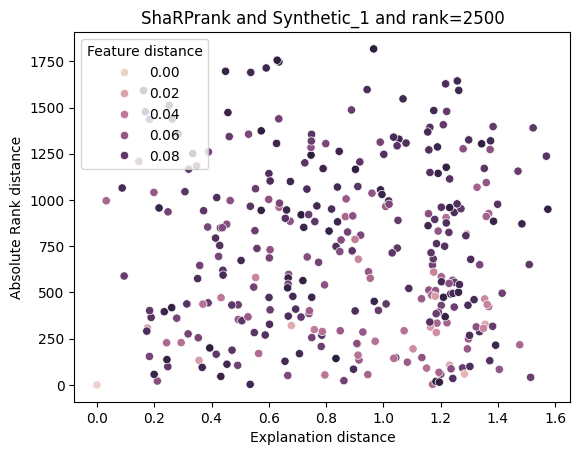

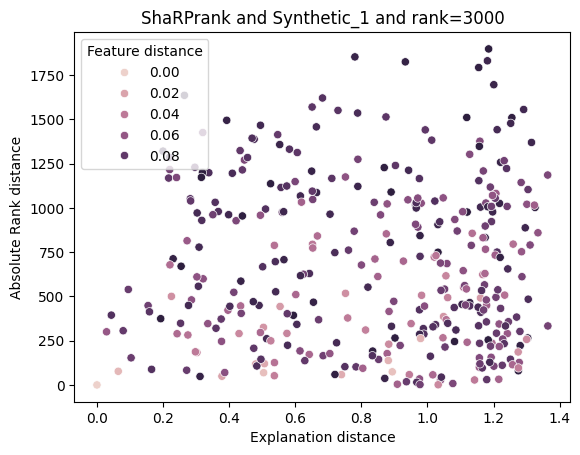

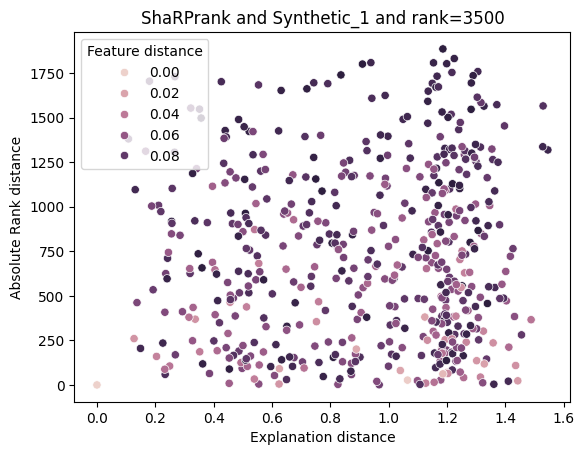

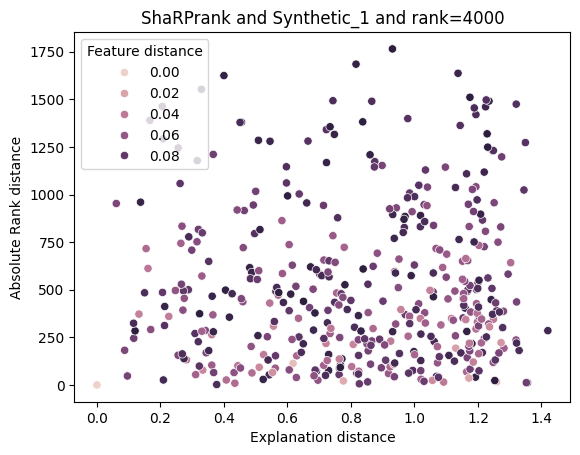

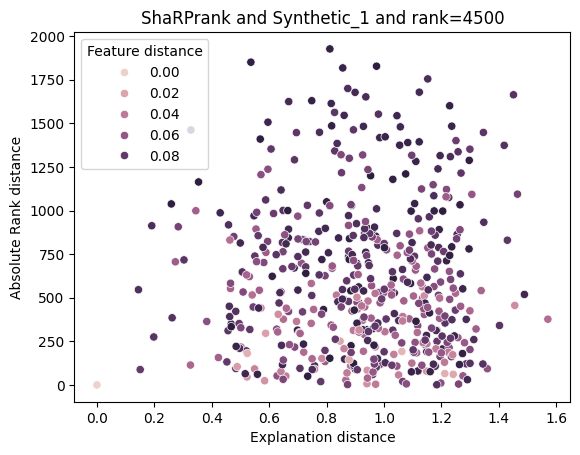

5000


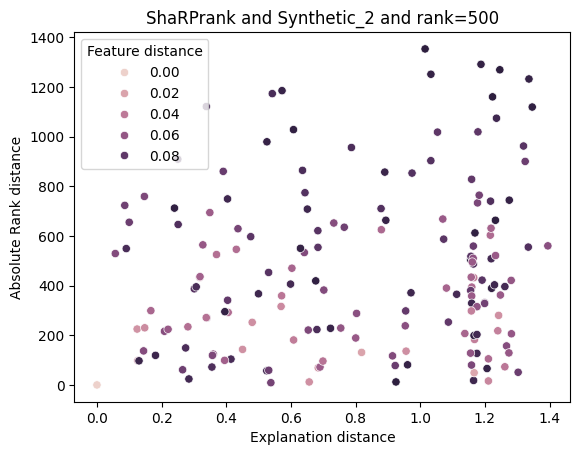

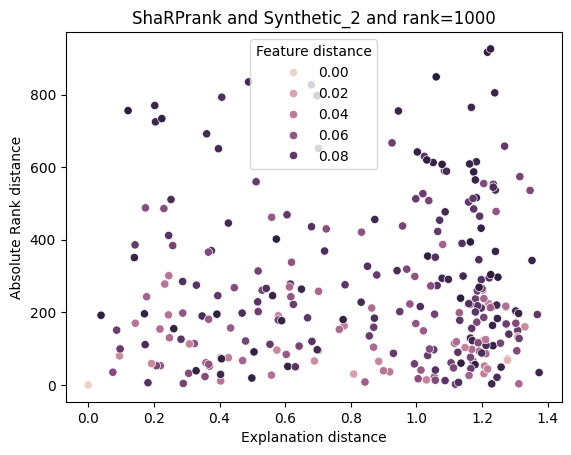

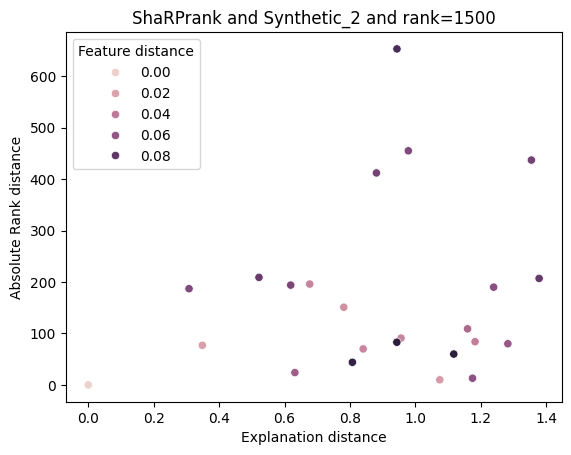

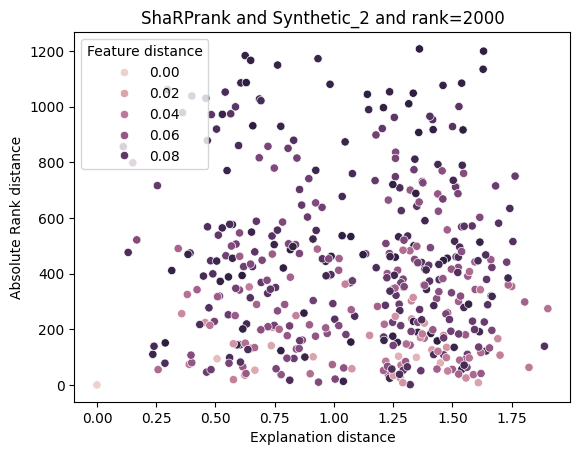

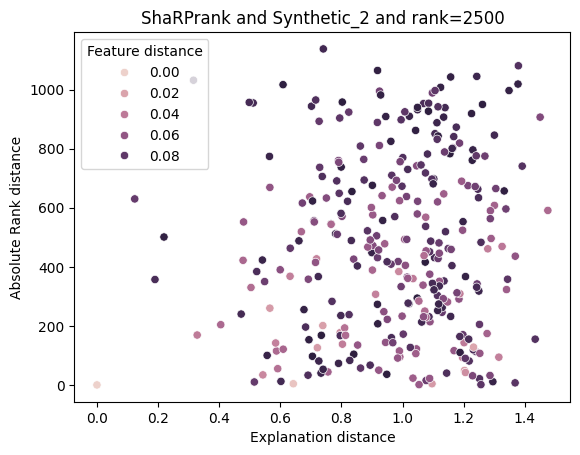

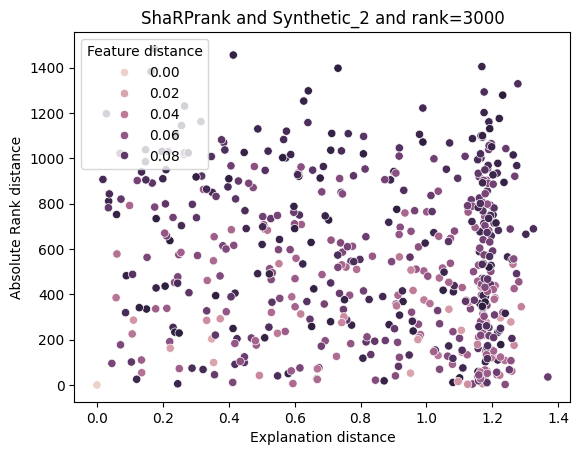

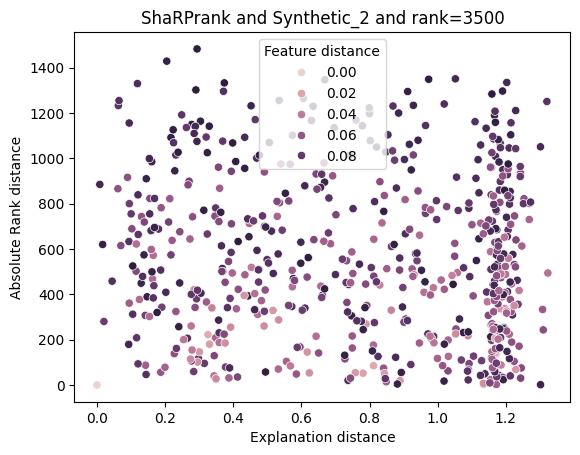

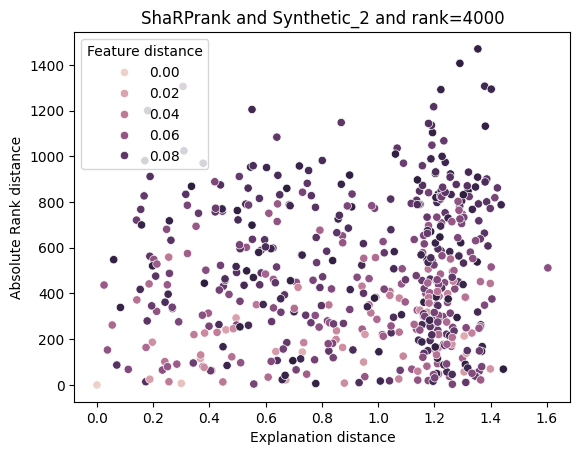

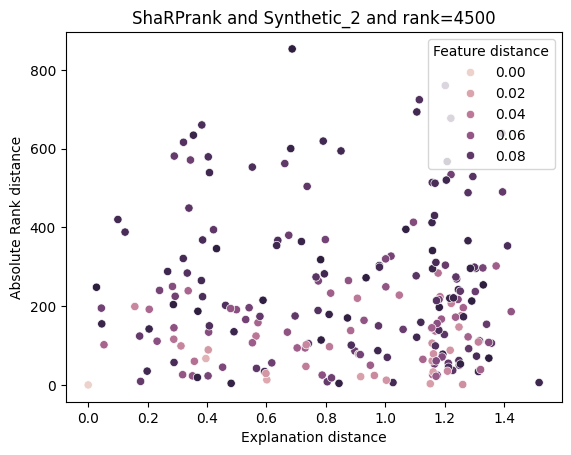

5000


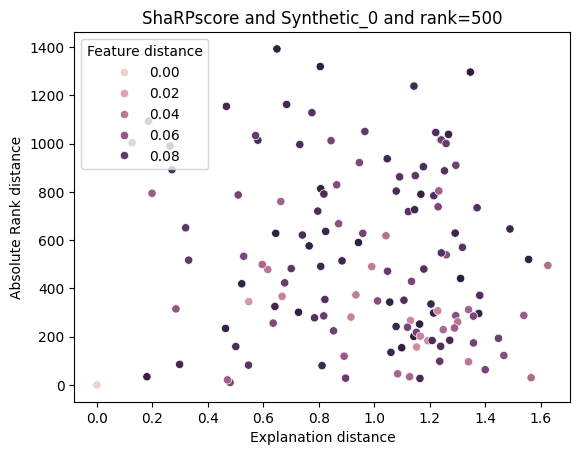

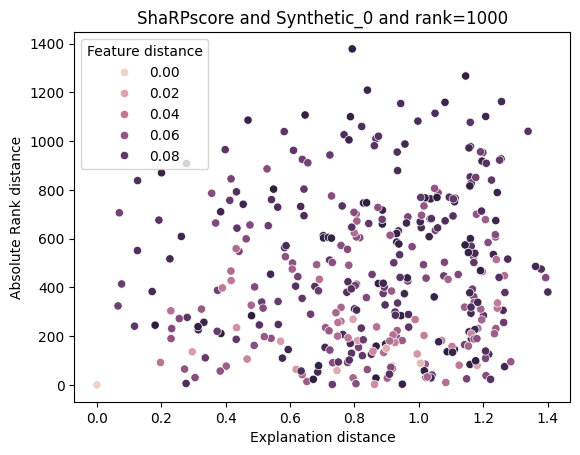

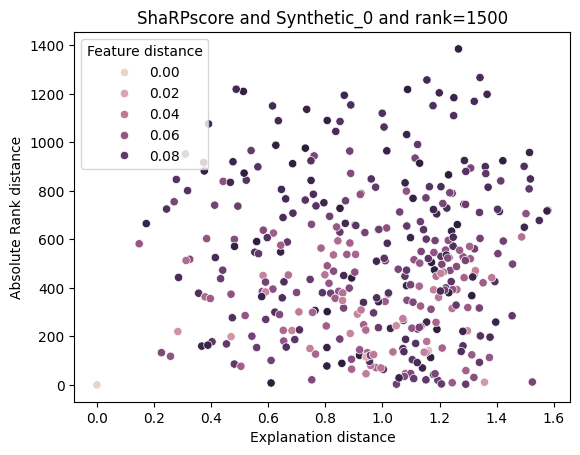

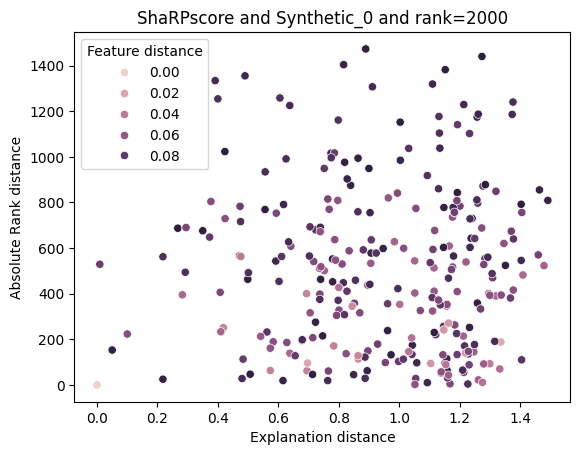

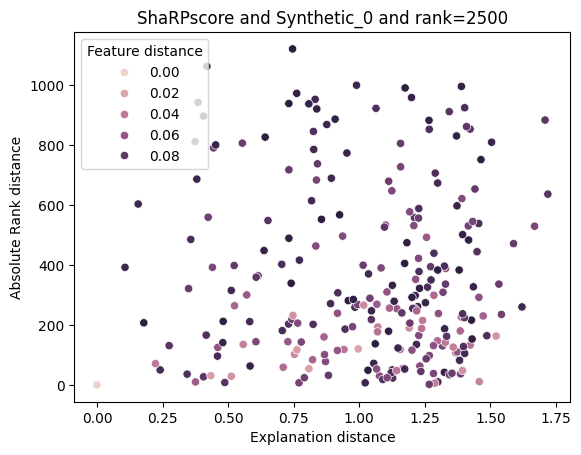

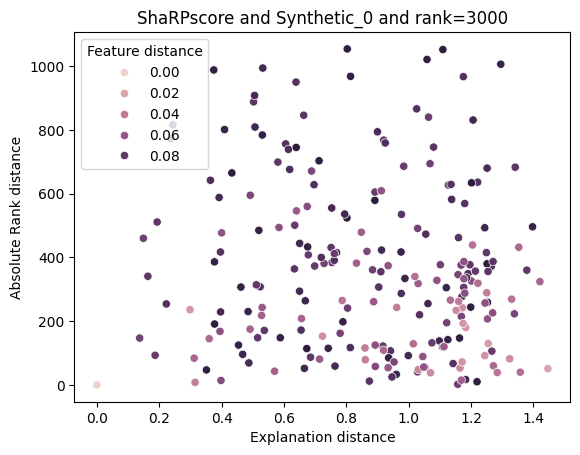

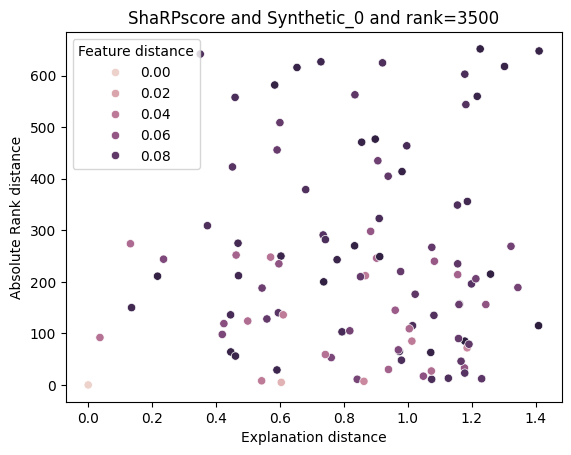

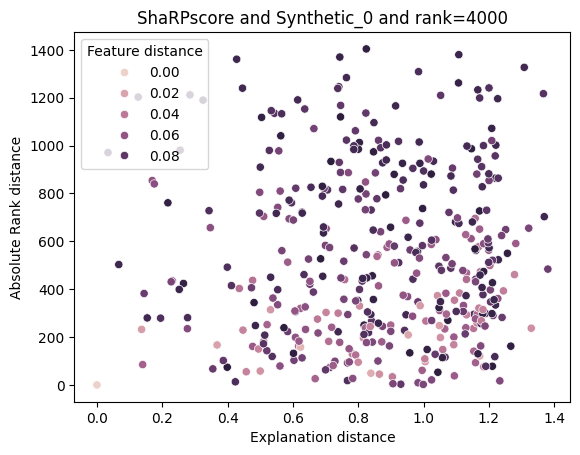

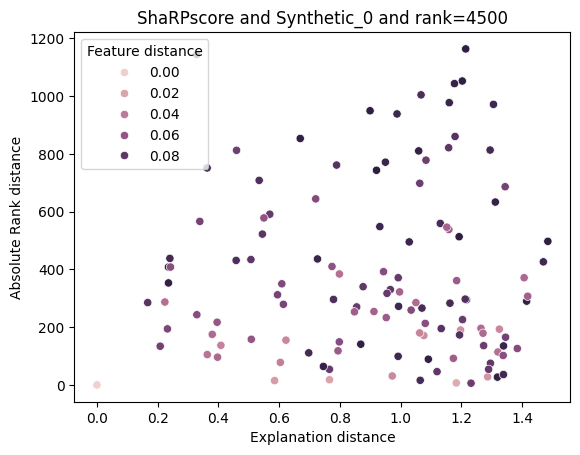

5000


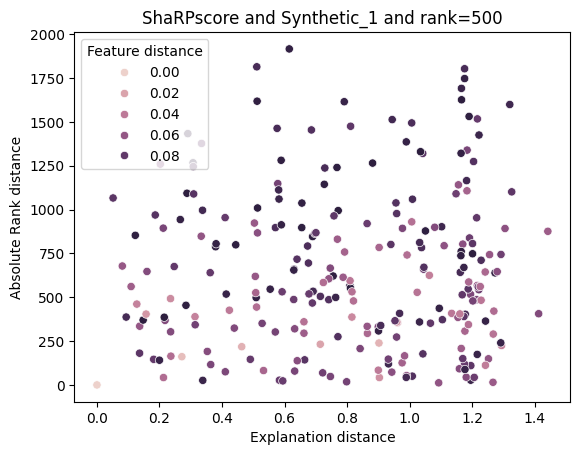

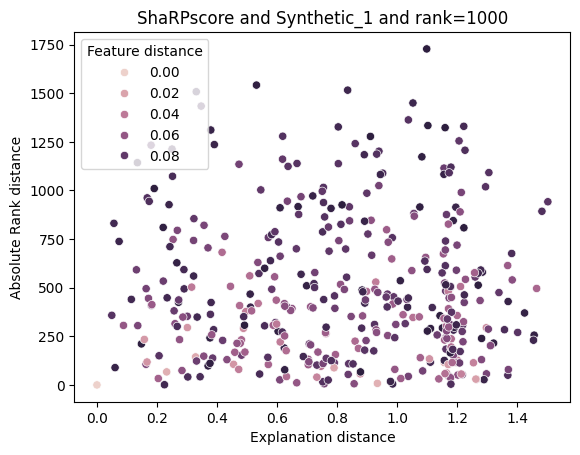

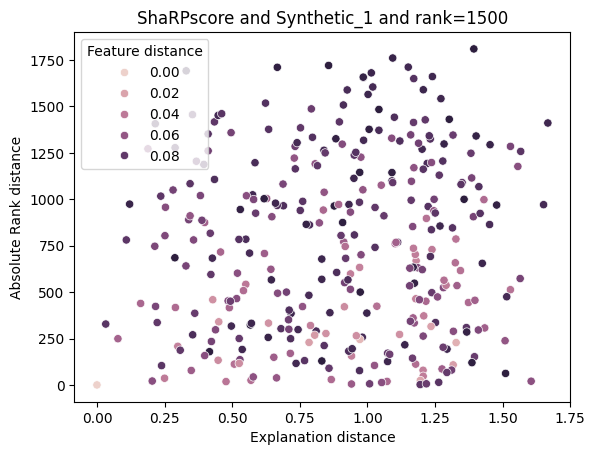

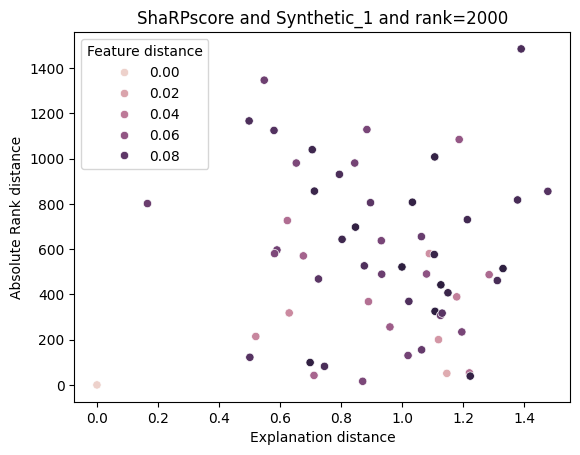

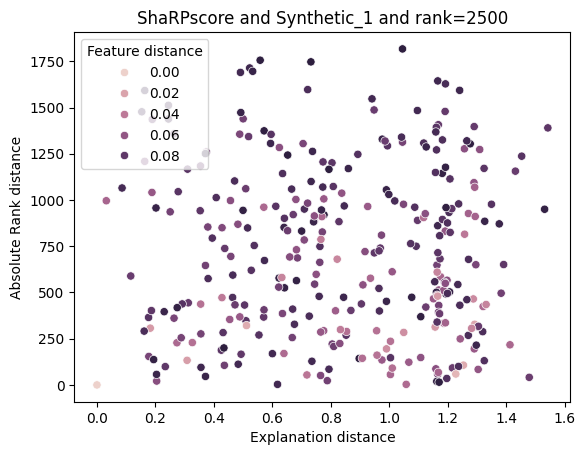

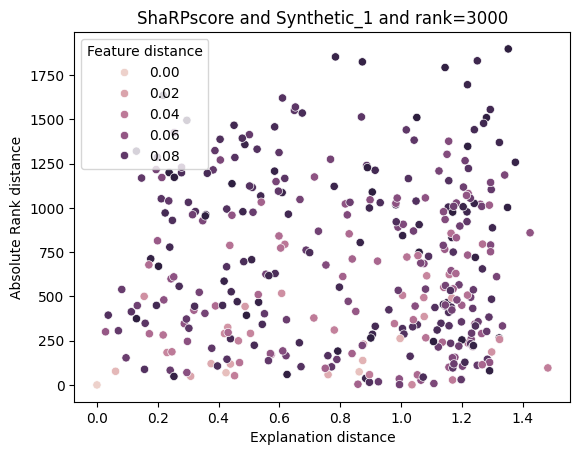

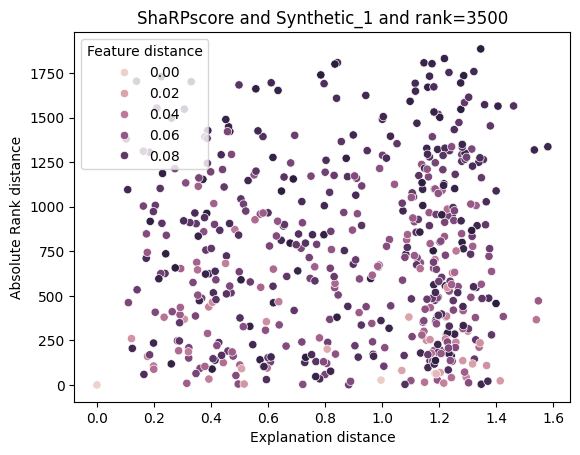

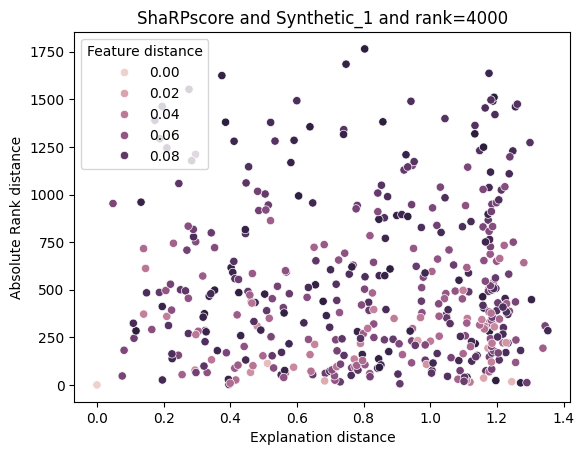

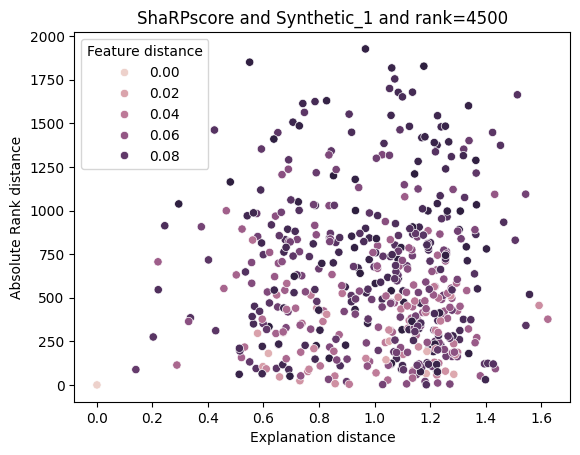

5000


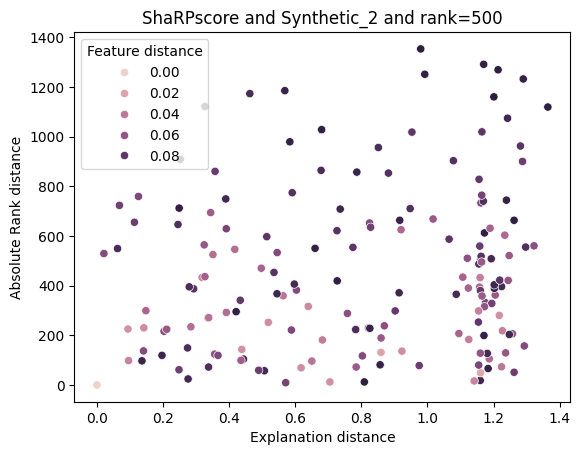

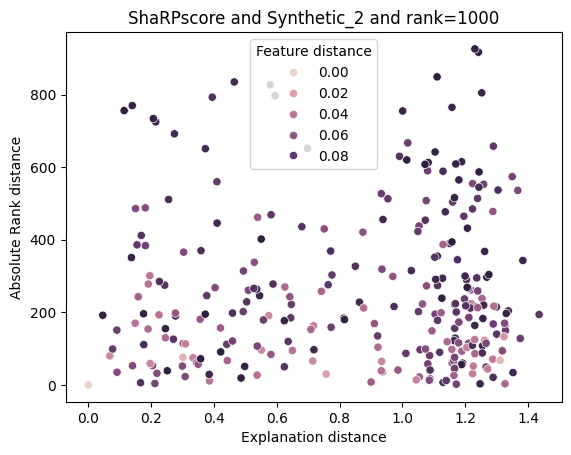

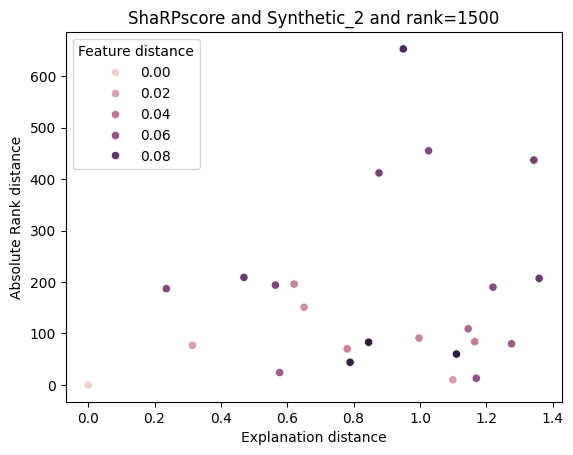

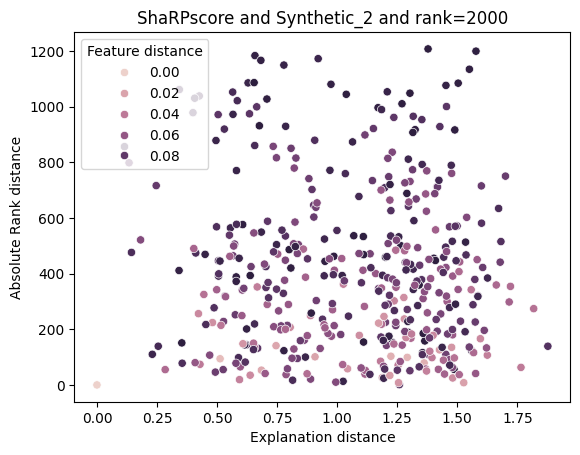

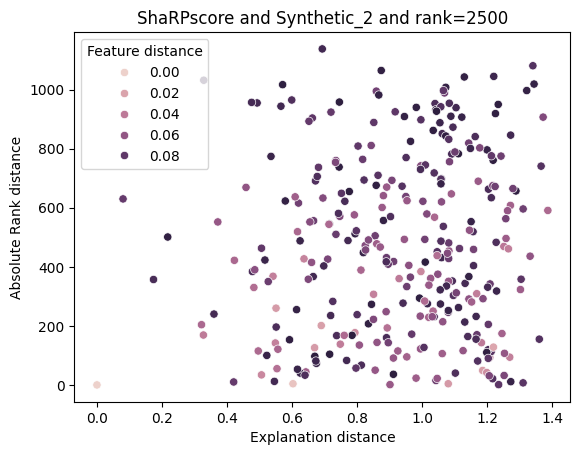

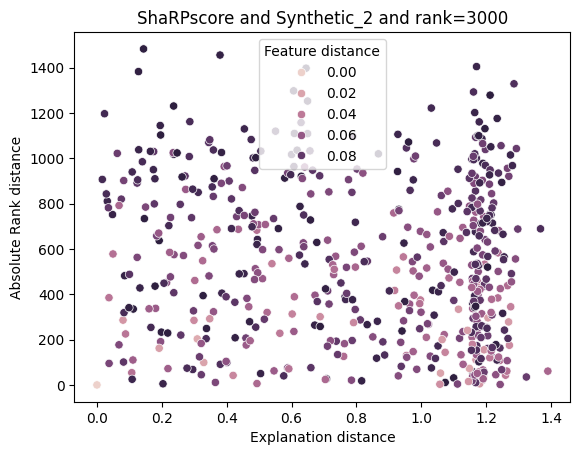

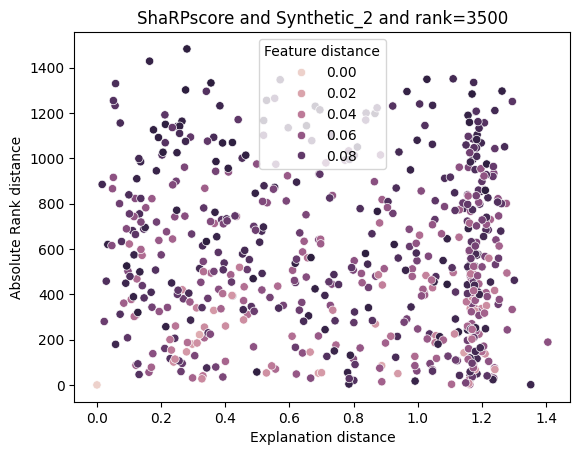

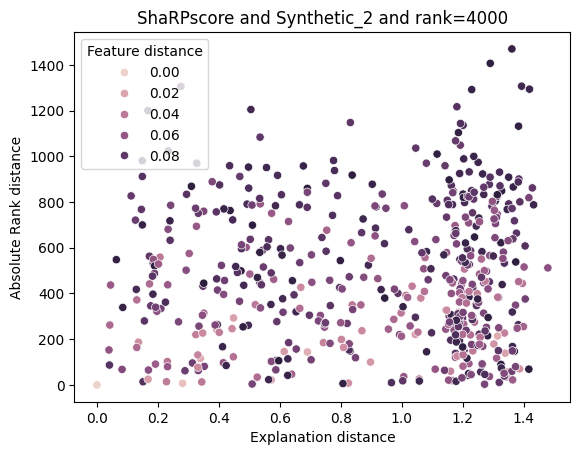

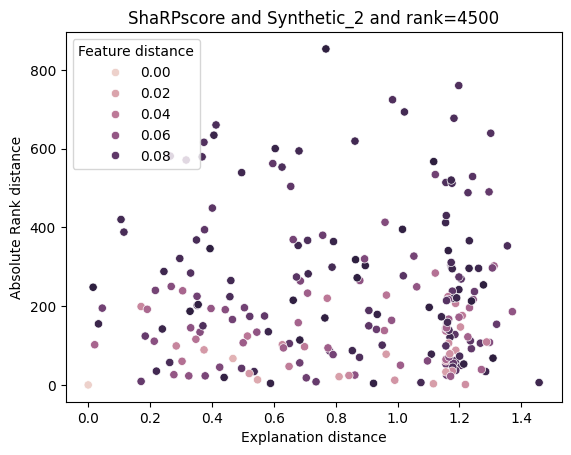

In [35]:
methods = [method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")]

for method in methods:
    for dataset in datasets:
        rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
        result = explanation_sensitivity_all_neighbors(
            dataset["data"][0], 
            results[dataset["name"]][method][0],
            rankings,
            measure="euclidean",
            #n_features=0.8,
            threshold=0.1
        )

        df_length = dataset['data'][0].shape[0]
        print(df_length)
        for plot_idx in [int(num/10*df_length) for num in range(1,10,1)]:
            measure_distances, rank_distances, feature_distances = result(row_idx=plot_idx)
    
            temp = pd.DataFrame()
    
            temp['Explanation distance'] = measure_distances
            temp['Absolute Rank distance'] = np.absolute(rank_distances)
            temp['Feature distance'] = feature_distances
            sns.scatterplot(data=temp, x="Explanation distance", y="Absolute Rank distance", hue="Feature distance")
            plt.title(f'{method} and {dataset["name"]} and rank={plot_idx}')
    
            plt.savefig(
            f"results/sensitivity-scatterplot-{dataset["name"]}-{method}-{plot_idx}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
            
            plt.show()


# Explanation Consistency

In [36]:
help(cross_method_explanation_consistency)

Help on function cross_method_explanation_consistency in module xai_ranking.metrics._consistency:

cross_method_explanation_consistency(results1, results2, measure='kendall', **kwargs)



In [37]:
methods = [method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")]

exp_cons_res = {}
exp_cons_sem = {}
for dataset in datasets:
    exp_cons_res[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    exp_cons_sem[dataset["name"]] = pd.DataFrame(index=methods, columns=methods)
    for method1, method2 in product(methods, methods):
        try:
            result = cross_method_explanation_consistency(
                results[dataset["name"]][method1][0], results[dataset["name"]][method2][0], measure="kendall"
            )

            exp_cons_res[dataset["name"]].loc[method1, method2] = result[0]
            exp_cons_sem[dataset["name"]].loc[method1, method2] = result[1]
        except:
            pass

In [38]:
exp_cons_res

{'Synthetic_0':                 SHAP ShaRPrank ShaRPscore
 SHAP             1.0  0.961133   0.963267
 ShaRPrank   0.961133       1.0   0.993067
 ShaRPscore  0.963267  0.993067        1.0,
 'Synthetic_1':                 SHAP ShaRPrank ShaRPscore
 SHAP             1.0    0.9156   0.914933
 ShaRPrank     0.9156       1.0   0.965733
 ShaRPscore  0.914933  0.965733        1.0,
 'Synthetic_2':                 SHAP ShaRPrank ShaRPscore
 SHAP             1.0  0.910867   0.920333
 ShaRPrank   0.910867       1.0   0.962267
 ShaRPscore  0.920333  0.962267        1.0}

In [39]:
avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)
for dataset, res_ in exp_cons_res.items():
    # if dataset != "Moving Company":
        # avg_exp_cons_res += res_
    avg_exp_cons_res += res_

avg_exp_cons_res /= len(datasets)
avg_exp_cons_res

/state/partition1/job-48952899/ipykernel_3805334/1798256637.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_exp_cons_res = pd.DataFrame(columns=methods, index=methods).fillna(0)


SHAP ShaRPrank ShaRPscore
SHAP             1.0    0.9292   0.932844
ShaRPrank     0.9292       1.0   0.973689
ShaRPscore  0.932844  0.973689        1.0

# Score to rank plots

Synthetic_0


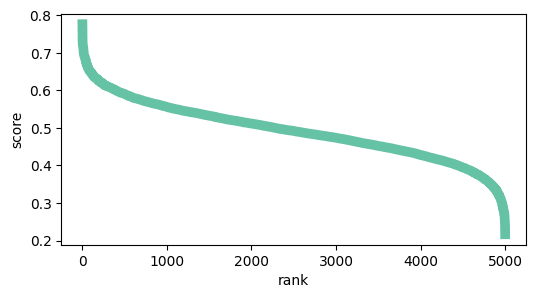

Synthetic_1


In [ ]:
# Score to rank plots

import seaborn as sns

for dataset in datasets:
    print(dataset["name"])
    df = pd.DataFrame()
    df['rank'] = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
    if dataset["name"] == "ATP":
        df['score'] = dataset["scorer"](dataset["data"][0]).values
    else:
        df['score'] = dataset["scorer"](dataset["data"][0])
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), sharey='row')
    ax = sns.lineplot(data=df, x="rank", y="score", linewidth = 7, c='#66c2a5')
    ax.set_ylabel("score")
    ax.set_xlabel("rank")

    fig.savefig(
    f"results/rank-vs-score-linechart-{dataset["name"]}.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
    )

    plt.show()
    
        

# Independence Analysis

In [ ]:
import sharp.visualization._aggregate as agg
from sharp.visualization import waterfall

In [ ]:
methods = [method for method in results["Synthetic_0"].keys() if not method.startswith("BATCH")]

for method in methods:
    for dataset in datasets:
        print(method)
        rankings = scores_to_ordering(dataset["scorer"](dataset["data"][0]))
        agg.strata_boxplots(dataset["data"][0], rankings, results[dataset["name"]][method][0]) 